### Import mujoco and numpy

In [1]:
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt


In [25]:
class HopperDynamics(object):
    def __init__(self, dt=0.01) -> None:
        self._m  = 0.1
        # self._I = np.diag([1.0, 1.0, 1.0])
        self._g  = 9.81 
        self._dt = dt

        def dfdt(x, u):
            p, pdot = x[0], x[1]
            f = u[0]
            pddot = f/self._m - self._g
            return ca.vertcat(pdot, pddot) 
        def f(x, u):
            return x + self._dt * self.dfdt(x, u)
        
        self.dfdt = dfdt 
        self.f = f 

hopper_model = HopperDynamics()


def loss(x, u):
    return ca.sumsqr(x-np.array([2.,0.]))

def phi(x):
    return x[0]-1.0

In [26]:
x  = ca.SX.sym('x', 2)
u  = ca.SX.sym('u', 1)

In [27]:
xnext = hopper_model.f(x, u)
F = ca.Function('F',[x,u], [xnext])#, ['x, y'], ['ode1', 'ode2'])

In [39]:
opti = ca.Opti()
tf = 2
N = int(tf/hopper_model._dt)
x = opti.variable(2, N+1) # Decision variables for state trajetcory
u = opti.variable(1, N)
p = opti.parameter(2, 1)  # initial cond Parameter (not optimized over)

opti.minimize(loss(x,u))

for k in range(0, N-1):
  opti.subject_to(x[:,k+1]==F(x[:,k],u[:,k]))
  opti.subject_to(phi(x[:,k+1])>=0)
  opti.subject_to(phi(x[:,k+1])*u[:,k]==0)
opti.subject_to(opti.bounded(0,u,1000))
opti.subject_to(x[:,0]==p)#np.array([2.,0.]))
# opti.subject_to(u>=0)
# opti.subject_to(x[:,-1] == np.array([10.,0.]))


In [40]:
opts = {
    # 'print_iteration' : False,
    # 'print_time' : False,
    'print_level' : 2
        # 'print_iter' : False,
        # 'print_header': False,
        # 'print_info' : False
}

# p_opts = {"expand":False}
# s_opts = {"print_level": 2}
opti.solver('ipopt')#, p_opts, s_opts)

# And choose a concrete value for p
opti.set_value(p, [2.,0.])
sol = opti.solve()

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     1594
Number of nonzeros in inequality constraint Jacobian.:      399
Number of nonzeros in Lagrangian Hessian.............:      601

Total number of variables............................:      602
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      599
Total number of inequality constraints...............:      399
        inequality constraints with only lower bounds:      199
   inequality constraints with lower and upper bounds:      200
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

RuntimeError: Error in Opti::solve [OptiNode] at .../casadi/core/optistack.cpp:159:
.../casadi/core/optistack_internal.cpp:999: Assertion "return_success(accept_limit)" failed:
Solver failed. You may use opti.debug.value to investigate the latest values of variables. return_status is 'Infeasible_Problem_Detected'

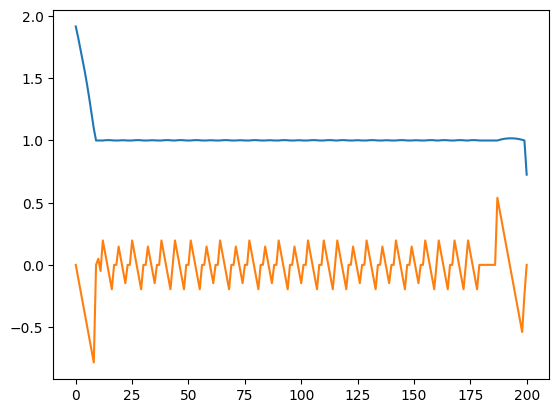

In [41]:
plt.plot(opti.debug.value(x).T)
# plt.plot(opti.debug.value(u).T)

In [34]:
plt.plot(sol.value(x))
# plt.plot(sol.value(u).T)

NameError: name 'sol' is not defined

In [28]:
sol.stats()

{'iter_count': 3,
 'iterations': {'alpha_du': [0.0, 0.0022499999948863638, 1.0, 1.0],
  'alpha_pr': [0.0, 0.99000099000099, 0.99009900990099, 1.0],
  'd_norm': [0.0, 116.89023100000001, 1.1687865885554778, 0.01157214444116363],
  'inf_du': [1.0, 434.62043659043655, 11.036712264527978, 10.999972067264025],
  'inf_pr': [10.0,
   0.09999009999009978,
   0.0009900009900007944,
   1.4210854715202004e-14],
  'mu': [0.1, 0.1, 0.1, 0.1],
  'obj': [0.0, 0.0, 4.188810396619829e-62, 2.402898531058718e-34],
  'regularization_size': [0.0, 0.0, 0.0, 0.0]},
 'n_call_callback_fun': 0,
 'n_call_nlp_f': 4,
 'n_call_nlp_g': 4,
 'n_call_nlp_grad': 1,
 'n_call_nlp_grad_f': 5,
 'n_call_nlp_hess_l': 3,
 'n_call_nlp_jac_g': 5,
 'n_call_total': 1,
 'return_status': 'Solve_Succeeded',
 'success': True,
 't_proc_callback_fun': 0.0,
 't_proc_nlp_f': 1.5e-05,
 't_proc_nlp_g': 0.000698,
 't_proc_nlp_grad': 0.000349,
 't_proc_nlp_grad_f': 3.9e-05,
 't_proc_nlp_hess_l': 0.001473,
 't_proc_nlp_jac_g': 0.00372599999999

In [3]:
def ineq_constr(x, args):
    q = x[:,:2]
    f = x[:,2:]
    _phi_out = vmap(phi)(q)
    return jnp.concatenate([-_phi_out, -f[:,0]])

def eq_constr(x, args):
    q = x[:,:2]
    f = x[:,2:]
    q0 = args['q0']
    qf = args['qf']
    _phi_out = vmap(phi)(q)
    return jnp.concatenate([
        (q[0] - q0).flatten(),
        (q[1:,:]-vmap(hopper_model.f)(q[:-1,:], f[:-1,:])).flatten(),
        (_phi_out*f[:,0]).flatten(),
        (q[-1] - qf).flatten()
    ])

In [4]:
args = {
    'q0' : np.array([5.,0.]),
    'qf' : np.array([10.,0.]) 
}

def loss(x, args):
    q, f = x[:,:2], x[:,2:]
    return jnp.array(0.)#jnp.mean(f**2)


In [5]:
time_horizon = int(6/hopper_model._dt)
# q = jnp.linspace(args['q0'], args['qf'], time_horizon, endpoint=True)
q = jnp.zeros((time_horizon, 2))
u = jnp.zeros((time_horizon, 1))
x = jnp.concatenate([q, u], axis=1)

In [6]:
opt_solver = AugmentedLagrangian(x, loss, eq_constr, ineq_constr, args=args, step_size=1e-3, c=1.0)

In [7]:
opt_solver.solve(eps=1e-5)

False

In [8]:
sol = opt_solver.get_solution()

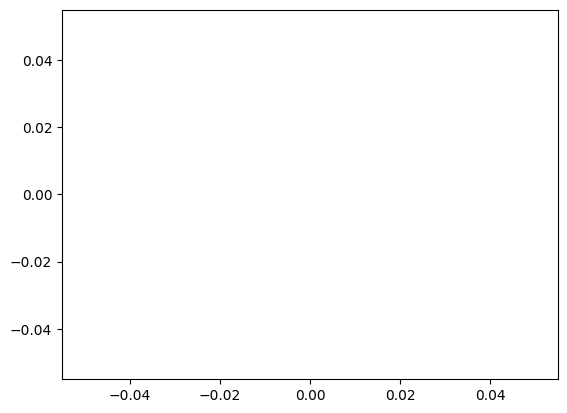

In [12]:
plt.plot(sol['x'][:,0])

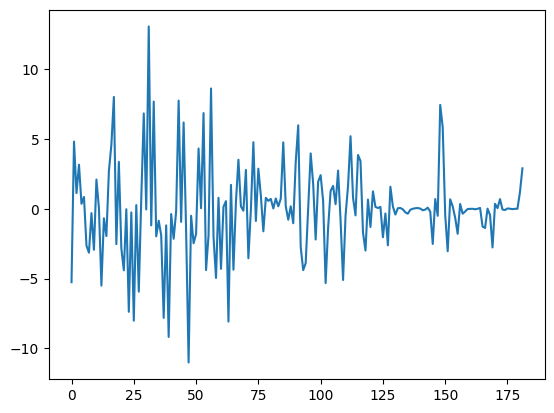

In [35]:
plt.plot(eq_constr(sol['x'], args))

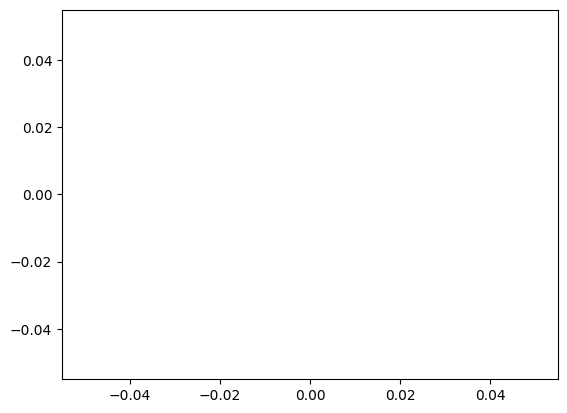

In [25]:
plt.plot(sol['x'])